MINFLUX localization metadata populations for all localizations of all tracks of all measurements in a folder, as read from .npy files.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import warnings
import copy

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

# warning suppression
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [24]:
def load_trackdata(path, loc_it=3):
    track_data = pd.DataFrame()  # for per-track parameters
        
    filelist = os.listdir(path)
    filelist_rois_all = [file for file in filelist if file.endswith('.npy')]
    filelist_conf = [file for file in filelist if 'conf' in file and 'analysis' not in file and '.png' not in file and '.tif' in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]

    for file_idx in range(len(filelist_conf)):
        print(f'Confocal file {file_idx+1}/{len(filelist_conf)}')
        curr_img_data = {'confidx': [], 'roiidx': [], 'tridx': [], 'tim0': [], 'x': [], 'y': [], 'tim': [], 'efo': []}
        file_conf = os.path.join(path, filelist_conf[file_idx])

        file_msr = os.path.join(path, filelist_msr[file_idx])

        print(file_conf)
        print(file_msr)
        conf_time = int(filelist_conf[file_idx].split('-')[1].split('_')[0])
        if file_idx > 0:
            conf_date_prev = copy.deepcopy(conf_date)
        else:
            conf_date_prev = 0
        conf_date = int(filelist_conf[file_idx].split('-')[0])
        if file_idx > 0 and conf_date == conf_date_prev:
            conf_time_prev = int(filelist_conf[file_idx-1].split('-')[1].split('_')[0])
        else:
            conf_time_prev = 0
        filelist_rois = [file for file in filelist_rois_all if int(file.split('-')[0])==conf_date and int(file.split('-')[1].split('_')[0])>conf_time_prev and int(file.split('-')[1].split('_')[0])<conf_time]

        for roi_idx, file in enumerate(filelist_rois):
            print(file)
            dataset = np.load(os.path.join(path, file))
            x = np.zeros((len(dataset),1))
            y = np.zeros((len(dataset),1))
            tid = np.zeros((len(dataset),1))
            tim = np.zeros((len(dataset),1))
            efo = np.zeros((len(dataset),1))
            for i in range(len(dataset)):
                x[i] = dataset[i][0][loc_it][2][0]
                y[i] = dataset[i][0][loc_it][2][1]
                tid[i] = dataset[i][4]
                tim[i] = dataset[i][3]
                efo[i] = dataset[i][0][loc_it][6]
            x_raw = x * 1e6
            y_raw = y * 1e6
            tid = tid.flatten()
            tim = tim.flatten()
            efo = efo.flatten()
            track_ids = list(map(int, set(tid)))
            track_ids.sort()

            for track in track_ids[::]:
                x_track = np.array([val for val,tr in zip(x_raw,tid) if tr==track]).flatten()
                y_track = np.array([val for val,tr in zip(y_raw,tid) if tr==track]).flatten()
                tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
                efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
                curr_img_data['tim0'].append(tim_track[0])
                curr_img_data['confidx'].append(file_idx)
                curr_img_data['roiidx'].append(roi_idx)
                curr_img_data['tridx'].append(track)
                curr_img_data['x'].append(x_track)
                curr_img_data['y'].append(y_track)
                tim_track = tim_track - tim_track[0]
                curr_img_data['tim'].append(tim_track)
                curr_img_data['efo'].append(efo_track)
        track_data = pd.concat([track_data, pd.DataFrame(curr_img_data)])
        track_data.reset_index(drop=True, inplace=True)
    return track_data

def load_trackdata_3d(top_path, loc_it=4, cellfolders=False):
    track_data = pd.DataFrame()  # for per-track parameters
    
    eventfolders_all = []
    samplefolders = os.listdir(top_path)
    if cellfolders:
        for samplefolder in samplefolders:
            if 'confocal' not in samplefolder:
                if os.path.isdir(os.path.join(top_path, samplefolder)):
                    cellfolders = os.listdir(os.path.join(top_path, samplefolder))
                    for cellfolder in cellfolders:
                        if os.path.isdir(os.path.join(top_path, samplefolder, cellfolder)):
                            eventfolders = os.listdir(os.path.join(top_path, samplefolder, cellfolder))
                            for eventfolder in eventfolders:
                                if os.path.isdir(os.path.join(top_path, samplefolder, cellfolder, eventfolder)):
                                    if 'nomfx' not in eventfolder:
                                        if 'manual' not in eventfolder:
                                            if any(filename.endswith('.npy') for filename in os.listdir(os.path.join(top_path, samplefolder, cellfolder, eventfolder))):
                                                eventfolders_all.append(os.path.join(top_path, samplefolder, cellfolder, eventfolder))
    else:
        for samplefolder in samplefolders:
            if 'confocal' not in samplefolder:
                if os.path.isdir(os.path.join(top_path, samplefolder)):
                    eventfolders = os.listdir(os.path.join(top_path, samplefolder))
                    for eventfolder in eventfolders:
                        if os.path.isdir(os.path.join(top_path, samplefolder, eventfolder)):
                            if 'nomfx' not in eventfolder:
                                if 'manual' not in eventfolder:
                                    if any(filename.endswith('.npy') for filename in os.listdir(os.path.join(top_path, samplefolder, eventfolder))):
                                        eventfolders_all.append(os.path.join(top_path, samplefolder, eventfolder))
    print(eventfolders_all)
    
    dates = []
    sampleidxs = []
    eventidxs = []
    cycleidxs = []
    cycletstarts = []
    roinames = []
    
    # loop over each eventfolder (which can contain one or multiple ROIs)
    tot_roicycles = 0
    for folder in eventfolders_all:
        filelist = os.listdir(folder)
        filelist_npy_all = [file for file in filelist if file.endswith('.npy') and 'test' not in file]
        tot_roicycles += len(filelist_npy_all)
    for folder in eventfolders_all:
        filelist = os.listdir(folder)
        filelist_npy_all = [file for file in filelist if file.endswith('.npy') and 'test' not in file]
        filelist_conf = [file for file in filelist if 'conf' in file and 'analysis' not in file and '.png' not in file and 'stack' not in file]
        # get all unique ROI names
        roinames_files = np.unique([file.split('_')[1].split('-')[0] for file in filelist_npy_all])
        # get date, sample, and event from folder name
        date = top_path.split('\\')[-1]
        sample = folder.split('\\')[-2].split('sample')[-1]
        event = folder.split('\\')[-1].split('e')[-1]
        # get all confocal image times
        conf_times = []
        for conffile in filelist_conf:
            conf_times.append(int(conffile.split('-')[1].split('_')[0]))
        conf_times = np.array(conf_times)
        for roiname in roinames_files:
            print(f'{roiname}')
            filelist_npy = [file for file in filelist_npy_all if roiname+'-' in file]
            for cycle in range(len(filelist_npy)):
                curr_img_data = {'date': [], 'sample': [], 'event': [], 'roiname': [], 'cycle': [], 'cycle_t_start_s': [], 'tridx': [], 'tim0': [], 'x': [], 'y': [], 'z': [], 'tim': [], 'efo': []}

                print(f'Cycle {cycle+1}/{len(filelist_npy)}')
                file_npy = os.path.join(folder, filelist_npy[cycle])
                
                # get correct confocal image for current cycle, and cycle time
                cycle_time = filelist_npy[cycle].split('-')[1].split('_')[0]
                if cycle == 0:
                    base_cycle_time_hms = datetime.strptime(cycle_time, '%H%M%S')
                cycle_time_hms = datetime.strptime(cycle_time, '%H%M%S')
                cycle_time_since_start_s = int((cycle_time_hms - base_cycle_time_hms).total_seconds())
                
                roi_name = int(file_npy.split('ROI')[1].split('-')[0])
                
                dataset = np.load(os.path.join(folder, file_npy))
                x = np.zeros((len(dataset),1))
                y = np.zeros((len(dataset),1))
                z = np.zeros((len(dataset),1))
                tid = np.zeros((len(dataset),1))
                tim = np.zeros((len(dataset),1))
                efo = np.zeros((len(dataset),1))
                for i in range(len(dataset)):
                    x[i] = dataset[i][0][loc_it][2][0]
                    y[i] = dataset[i][0][loc_it][2][1]
                    z[i] = dataset[i][0][loc_it][2][2]
                    tid[i] = dataset[i][4]
                    tim[i] = dataset[i][3]
                    efo[i] = dataset[i][0][loc_it][6]
                x_raw = x * 1e6
                y_raw = y * 1e6
                z_raw = z * 1e6
                z_raw = z_raw * 0.7  # z scaling for immersion mismatch
                tid = tid.flatten()
                tim = tim.flatten()
                efo = efo.flatten()
                track_ids = list(map(int, set(tid)))
                track_ids.sort()

                # save roi-and-cycle-specific parameters
                dates.append(date)
                sampleidxs.append(sample)
                eventidxs.append(event) 
                roinames.append(roi_name)
                cycleidxs.append(cycle)
                cycletstarts.append(cycle_time_since_start_s)
                
                for track in track_ids[::]:
                    x_track = np.array([val for val,tr in zip(x_raw,tid) if tr==track]).flatten()
                    y_track = np.array([val for val,tr in zip(y_raw,tid) if tr==track]).flatten()
                    z_track = np.array([val for val,tr in zip(z_raw,tid) if tr==track]).flatten()
                    tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
                    efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
                    curr_img_data['tim0'].append(tim_track[0])
                    curr_img_data['date'].append(date)
                    curr_img_data['sample'].append(sample)
                    curr_img_data['event'].append(event)
                    curr_img_data['roiname'].append(roi_name)
                    curr_img_data['cycle'].append(cycle)
                    curr_img_data['cycle_t_start_s'].append(cycle_time_since_start_s)
                    curr_img_data['tridx'].append(track)
                    curr_img_data['x'].append(x_track)
                    curr_img_data['y'].append(y_track)
                    curr_img_data['z'].append(z_track)
                    tim_track = tim_track - tim_track[0]
                    curr_img_data['tim'].append(tim_track)
                    curr_img_data['efo'].append(efo_track)
                track_data = pd.concat([track_data, pd.DataFrame(curr_img_data)])
                track_data.reset_index(drop=True, inplace=True)
    return track_data

In [33]:
#foldername = os.path.join(parentdir, 'exampledata\\cav1\\site-sm\\240925')
#track_data = load_trackdata(foldername)
#dataset_tag = foldername.split('\\')[-1]

#foldername = os.path.join(parentdir, 'exampledata\\dyn1\\241121')
#track_data = load_trackdata_3d(foldername, cellfolders=True)
#dataset_tag = foldername.split('\\')[-1]

foldername = os.path.join(parentdir, 'exampledata\\gag\\250117')
track_data = load_trackdata_3d(foldername, cellfolders=False)
dataset_tag = foldername.split('\\')[-1]

['c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\gag\\250117\\sample2\\e1']
ROI1
Cycle 1/4
Cycle 2/4
Cycle 3/4
Cycle 4/4
ROI5
Cycle 1/4
Cycle 2/4
Cycle 3/4
Cycle 4/4


In [34]:
xs = [arr for arr in track_data['x']]
tracklens = np.array([len(arr) for arr in xs])
efos = np.concatenate([arr for arr in track_data['efo']])
dts = np.concatenate([np.diff(arr) for arr in track_data['tim']])
tracklens_time = np.concatenate([[arr[-1]-arr[0]] for arr in track_data['tim']])

In [35]:
print('Track lengths [ms]')
print(np.median(tracklens_time*1e3))
print(np.mean(tracklens_time*1e3))
print(np.std(tracklens_time*1e3))
print('dts [µs]')
print(np.min(dts*1e6))
print(np.median(dts*1e6))
print(np.mean(dts*1e6))
print(np.std(dts*1e6))
print('efo [kHz]')
print(np.median(efos/1e3))
print(np.mean(efos/1e3))
print(np.std(efos/1e3))

Track lengths [ms]
21.42577500000087
50.21931548843192
119.93059812066744
dts [µs]
357.1250000007353
359.0750000004306
495.64402813721057
651.2466427850707
efo [kHz]
150.03750937734435
165.3707148365867
70.71666807357826


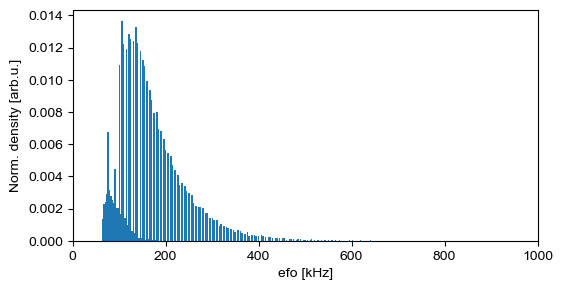

In [36]:
# plot localization brightness efo
fig = plt.figure(figsize=(6, 3))
plt.hist(efos/1e3, bins=np.arange(0, 1e3, 3), density=True)
plt.ylabel('Norm. density [arb.u.]')
plt.xlabel('efo [kHz]')
plt.xlim(0,1e3)
plt.show()

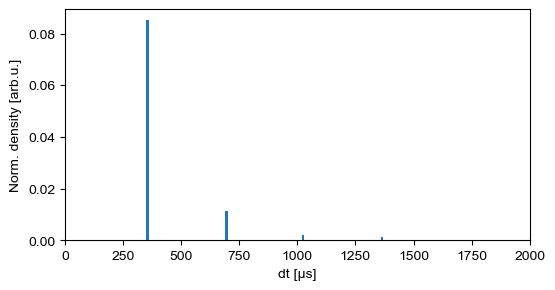

In [37]:
# plot time between localizations dt
fig = plt.figure(figsize=(6, 3))
plt.hist(dts*1e6, bins=np.arange(0, 1.5e3, 0.01e3), density=True)
plt.ylabel('Norm. density [arb.u.]')
plt.xlabel('dt [µs]')
plt.xlim(0,2e3)
plt.show()

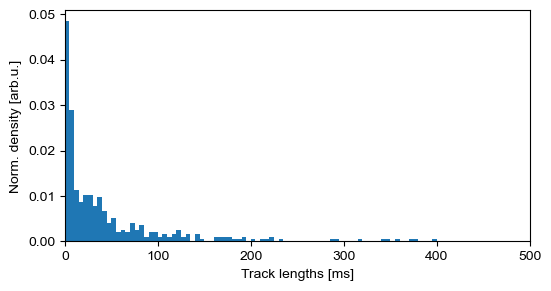

In [38]:
# plot track lengths
fig = plt.figure(figsize=(6, 3))
plt.hist(tracklens_time*1e3, bins=np.arange(0, 0.5e3, 0.5e1), density=True)
plt.ylabel('Norm. density [arb.u.]')
plt.xlabel('Track lengths [ms]')
plt.xlim(0,0.5e3)
plt.show()